# The popular approach for image classification - Transfer Learning

I chose transfer learning because of number of training/validation samples I have. I have around 2400 training images (1200 for NSFW and 1200 for SFW), 800 validation images (400 for NSFW and 400 for SFW), and 800 test images, following the 60%-20%-20-% split. I thought of approaching transfer learning because it is possible to get a high accuracy even with less amount of examples to train/validate on. 

***The model I used in this example is Inception V3.***

# 1) Loading the necessary libraries

In [2]:
import os
import cv2
import keras
import random
from IPython.display import Image
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.imagenet_utils import decode_predictions
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.optimizers import Adam
from keras.models import load_model
from keras.preprocessing import image

# 2) Defining the architecture

First, I load the train and validation directories. Next, I load the InceptionV3 model with weights loaded from the Imagenet dataset. I remove the finaly classifying layer and add a couple of my own layers (1 intermediate dense layer, 1 dropout layer 20%, and a final classifying layer). 

Initially I had used the 'RelU' activation and 1 output in the final layer, but that did not provide me with the results I wanted, so I finally configured it to 'Softmax' and 2 respectively. As a result, I change the class_mode from  'binary' to 'categorical'.

I also define a callback function that stops if my model accuracy increases to 99.9% (Spoiler alert: It never reaches there).

In [ ]:
nsfw_images = [fn for fn in os.listdir(r'C:\Users\Harshinee Sriram\OneDrive\Desktop\Wikimedia\NSFW classifier\Data\Train\NSFW') if fn.endswith('.jpg')]
sfw_images = [fn for fn in os.listdir(r'C:\Users\Harshinee Sriram\OneDrive\Desktop\Wikimedia\NSFW classifier\Data\Train\SFW') if fn.endswith('.jpg')]

train_dir = r'C:\Users\Harshinee Sriram\OneDrive\Desktop\Wikimedia\NSFW classifier\Data\Train'
validation_dir = r'C:\Users\Harshinee Sriram\OneDrive\Desktop\Wikimedia\NSFW classifier\Data\Validation'

pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top=False, 
                                weights = 'imagenet')

for layer in pre_trained_model.layers:
    layer.trainable=False
    
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('acc')>0.999):
            print("\nReached 99.9% accuracy so this training has been cancelled.")
            self.model.stop_training = True
            
x = layers.Flatten()(pre_trained_model.output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers. Dense(2, activation='softmax')(x)

model = Model(pre_trained_model.input, x)
model.compile(optimizer = Adam(lr=0.0001),
             loss='binary_crossentropy',
             metrics= keras.metrics.BinaryAccuracy())

train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator( rescale = 1.0/255.)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 30,
                                                    class_mode = 'categorical', 
                                                    target_size = (150, 150))

validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 30,
                                                          class_mode  = 'categorical', 
                                                          target_size = (150, 150))

# 3) Training and performance

Now comes the training. I only trained it for 10 epochs as that seemed sufficient. I was able to achieve an **accuracy of 97.95% on the Validation set**! I have also attached the train and validation accuracy and loss progressions with each epoch. 

In [ ]:
batch_size = 30
callbacks = myCallback()
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = int(2400/batch_size),
            epochs = 10,
            validation_steps=int(800/batch_size),
            verbose=2)

acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

model.save('model_inceptionV3.h5')

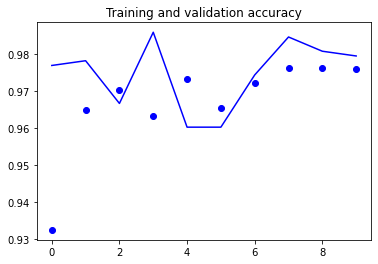

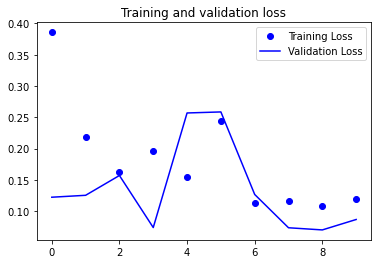

In [10]:
os.chdir(r'C:\\Users\\Harshinee Sriram\\OneDrive\\Desktop\\Wikimedia\\NSFW classifier\\')
display(Image(filename=r'Training_Validation_Accuracy_InceptionV3.png'))
display(Image(filename=r'Training_Validation_Loss_InceptionV3.png'))

# 4) Testing our model

I wrote the following script to generate either ***5 random images from the test set*** or ***a predefined set of 4 images***. You may use either to see the results. 

In the 2B) Notebook, I use the predefined set as the NSFW images in that list have been handpicked.

Of course, if you choose to use set img_list (containing any 5 random images), you must note that due to the nature of these images, they could be highly inappropriate.

In [ ]:
os.chdir(r'C:\\Users\\Harshinee Sriram\\OneDrive\\Desktop\\Wikimedia\\NSFW classifier\\Data\\Test\\')

number_of_random_images = 0
img_list = [] # LIST CONTAINING ANY 5 RANDOM IMAGES FROM THE TEST FOLDER

while (number_of_random_images<5):
    img_list.append(random.choice(os.listdir(os.getcwd())))
    number_of_random_images = number_of_random_images + 1
    
img_list2 = ['img 70.jpg', 'img 74.jpg', 'img 100.jpg', 'img 105.jpg'] # LIST CONTAINING HANDPICKED IMAGES

for img in img_list2:
    display(Image(filename=img, height=100, width=100))
    img = image.load_img(img, target_size=(150, 150))
    img = image.img_to_array(img)
    img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
    img = preprocess_input(img)
    yhat = model.predict(img)
    if(np.argmax(yhat) == 0):
        print("This is an NSFW image")
    else:
        print("This is a SFW image")   

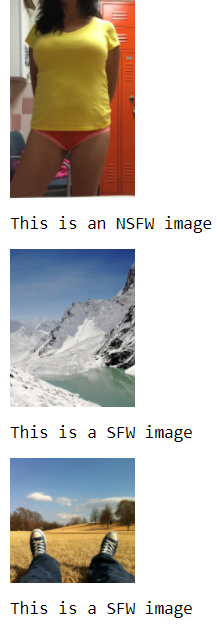

In [13]:
os.chdir(r'C:\\Users\\Harshinee Sriram\\OneDrive\\Desktop\\Wikimedia\\NSFW classifier\\')
Image(filename='Test_results.PNG')

# 5) Next steps

Even though the advantage in this is that the train, validation, and test datasets have similar distribution and instances, here are the following disadvantages/room for improvements:

- Not enough training data, especially for NSFW artworks 
- Not enough training data for POC: majority of the NSFW images that were scrapped are of caucasian people
- Building a model to detect NSFW content in videos

I will be addressing the following soon. Additionally, I am open to new methods of thinking and/or computational approach.